In [4]:
import warnings
warnings.filterwarnings("ignore")

import os.path
import ssm
import pickle
import numpy as np
import pandas as pd
import scipy
import copy
from tqdm import tqdm

from runwise_ts_log_data import get_ts_log_data_blocked

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import to_rgba
import seaborn as sns

from sympy.utilities.iterables import multiset_permutations
from ssm.util import *
from scipy.stats import ttest_ind,ranksums

In [5]:
K = 6
D = 10
N = 85
num_subjs = 92
num_resamples = 400
M=20

In [6]:
from sklearn.cluster import KMeans
from munkres import Munkres
from sklearn.metrics.pairwise import cosine_similarity

def reference_comms(num_states, X):
    X = np.concatenate(X, axis=-1)
    print(X.shape)
    kmeans = KMeans(
        n_clusters=num_states, 
        init='k-means++', n_init=50,
        random_state=74
    ).fit(X=X.T)
    print('found reference')
    return kmeans.cluster_centers_.T # num_rois x num_comms

def align_two_partitions(source_comms, target_comms):
    # align source onto target
    
    # distatnce matrix
    Dd = 1 - cosine_similarity(target_comms.T, source_comms.T)
    # Hungarian permutation method
    best_pi = list(zip(*Munkres().compute(Dd)))[1]
    source_comms = source_comms[:, best_pi]
    return source_comms, best_pi

def align_partitions(num_states, X):
    comm_cntrs = reference_comms(num_states, X)
    print(comm_cntrs.shape)
    best_pis = []
    for idx, comms in tqdm(enumerate(X)):
        _, best_pi = align_two_partitions(
            source_comms=comms, 
            target_comms=comm_cntrs
        )
        best_pis.append(best_pi)
    return best_pis

def get_attractors(idx_resample):
    if idx_resample<=100:
        with open(f'pkl/rslds_emoprox2_K{K}_D{D}_N{N}_{num_subjs}subjs_resample{idx_resample}.pkl','rb') as f:
            model, q, elbos, resampled_subj_list = pickle.load(f)
    elif idx_resample>100:
        with open(f'pkl/rslds_emoprox2_K{K}_D{D}_N{N}_M{M}_{num_subjs}subjs_resample{idx_resample}.pkl','rb') as f:
            model, q, elbos, resampled_subj_list = pickle.load(f) 
    As = model.dynamics.As
    bs = model.dynamics.bs
    C = model.emissions.Cs[0]
    d = model.emissions.ds[0]
    attractors = np.zeros((K,N))
    for k in range(K):
        attractors[k,:] = C@(np.linalg.inv(np.eye(D)-As[k])@bs[k])+d
    attractors /= np.expand_dims(np.linalg.norm(attractors,axis=1),axis=1)
    return attractors.T

all_attractors = []    
for idx_resample in tqdm(range(1,1+num_resamples)):
    all_attractors.append(get_attractors(idx_resample))
print(all_attractors[0].shape)

all_perms = align_partitions(K,all_attractors)

  0%|          | 0/400 [00:00<?, ?it/s]

100%|██████████| 400/400 [12:43<00:00,  1.91s/it]


(85, 6)
(85, 2400)
found reference
(85, 6)


400it [00:00, 1985.07it/s]


In [7]:
with open('pkl/emoprox2_dataset_timeseries+inputs_MAX85.pkl','rb') as f:
    orig_df = pickle.load(f)
subj_list = sorted(orig_df['pid'].unique())
subj_list = subj_list[:] # remove first 30 subjects
orig_df = orig_df[orig_df['pid'].isin(subj_list)]

In [23]:
from email.errors import HeaderDefect


def get_attractor(model):
    attractors = np.zeros((K,D))
    for idx_state in range(K):
        A = model.dynamics.As[idx_state]
        b = model.dynamics.bs[idx_state]
        attractor = np.linalg.inv(np.eye(D)-A) @ b
        attractors[idx_state,:] = attractor
    return attractors

def cosine(v1,v2):
    return np.dot(v1, v2)/(np.linalg.norm(v1)*np.linalg.norm(v2))

def get_df(idx_resample,perm):
    if idx_resample<=100:
        with open(f'pkl/rslds_emoprox2_K{K}_D{D}_N{N}_{num_subjs}subjs_resample{idx_resample}.pkl','rb') as f:
            model, q, elbos, resampled_subj_list = pickle.load(f)
    elif idx_resample>100:
        with open(f'pkl/rslds_emoprox2_K{K}_D{D}_N{N}_M{M}_{num_subjs}subjs_resample{idx_resample}.pkl','rb') as f:
            model, q, elbos, resampled_subj_list = pickle.load(f) 
    
    model.permute(perm)
    # model.permute(np.array([0, 1, 3, 2, 4, 5])) #300 resamples
    # model.permute(np.array([1,2,4,3,5,0])) #100 resamples
    model.permute(np.array([2,4,3,0,1,5])) #400 resamples
    
    attractors = get_attractor(model)

    resampled_df = []
    for pid in resampled_subj_list:
        resampled_df.append(orig_df[orig_df['pid']==pid])
    resampled_df = pd.concat(resampled_df).reset_index().drop('index',axis=1)
    df = resampled_df

    df['continuous_states'] = [None]*df.shape[0]
    df['discrete_states'] =[None]*df.shape[0]
    df['sims'] =[None]*df.shape[0]
    hrflag=0
    prox_bins = list(np.arange(M//2)/(M//2))[1:]
    dir_bins = [0]
    nprox = len(prox_bins)+1
    ndir = len(dir_bins)+1
    for idx_row in range(df.shape[0]):
        prox = df.loc[idx_row]['proximity']
        prox = prox - prox.min()
        prox = prox / prox.max()
        proxd = np.digitize(prox, bins=prox_bins)
        dird = 1-np.digitize(df.loc[idx_row]['direction'], bins=dir_bins)
        stim_category = (nprox*ndir-1)*dird+((-1)**dird)*proxd
        input = np.roll(np.eye(nprox*ndir)[stim_category],shift=hrflag,axis=0)

        y = df.loc[idx_row]['timeseries']
        x = q.mean_continuous_states[idx_row]
        z = model.most_likely_states(x,y,input=input)
        df.at[idx_row,'continuous_states'] = x
        df.at[idx_row,'discrete_states'] = z
        prox = df.loc[idx_row]['proximity']
        prox = prox - prox.min()
        prox = prox / prox.max()
        df.at[idx_row,'proximity'] = prox
        
        zs = z.copy()
        xs = x.copy()
        stim_categories = stim_category.copy()
        hrf_shift = 3
        # zs = zs[hrf_shift:]
        # xs = xs[hrf_shift:,:]
        # stim_categories = np.roll(stim_categories,shift=hrf_shift)[hrf_shift:]
        zs_shift = np.roll(zs.copy(),shift=-hrf_shift)
        sims = []#[0]*hrf_shift
        for z,x,stim,z_shift in zip(zs,xs,stim_categories,zs_shift):
            dx = attractors[z_shift]-x
            v = model.dynamics.Vs[z][:,stim]
            sim = cosine(dx,v)
            sims.append(sim)
        df.at[idx_row,'sims'] = sims

    return df,model

In [24]:
all_dfs = {}
all_models = {}
for idx_resample in tqdm(range(1,num_resamples+1)):
    all_dfs[idx_resample],all_models[idx_resample] = get_df(idx_resample,np.array(all_perms[idx_resample-1]))

100%|██████████| 400/400 [38:31<00:00,  5.78s/it]


In [25]:
winlen = 6

def get_transition_responses(y,z,st_i,win=winlen):
    ret = []
    for t in range(win-1,len(z)):
        if z[t]==st_i: 
            if t==len(z)-1:
                if np.all(z[t-win+1:t+1]==st_i):
                    ret.append(y[t-win+1:t+1])
            elif z[t+1]!=st_i:
                if np.all(z[t-win+1:t+1]==st_i):
                    ret.append(y[t-win+1:t+1])
    if len(ret)>0: return np.mean(np.stack(ret,axis=0),axis=0)
    else: return None

def bootstrap_err(sample):
    means = np.zeros(100)
    for i in range(100):
        means[i] = np.random.choice(sample,len(sample),replace=True).mean()
    return means.std()*1.96

def bootstrap_err_matrix(X):
    ret = np.zeros_like(X[0])
    for i in range(X[0].shape[0]):
        for j in range(X[0].shape[1]):
            ret[i,j] = bootstrap_err(X[:,i,j])
    return ret

def get_mean_transition_response(df,state_from):
    subj_list = df.pid.unique()
    trans_responses = []
    for pid in subj_list:
        df_subj = df[df.pid==pid]
        z_subj = np.hstack(list(df_subj.discrete_states.values))
        y_subj = np.hstack(list(df_subj['sims'].values))
        y_trans = get_transition_responses(y_subj,z_subj,state_from)
        if y_trans is not None: trans_responses.append(y_trans)
    trans_responses = np.stack(trans_responses,axis=0)
    mean_trans_response = trans_responses.mean(axis=0)
    return mean_trans_response

In [26]:
trans_list = [0,1,2,3,4]

In [27]:
with open(f'pkl/state_masks_K{K}_D{D}_N{N}_{num_subjs}subjs_{num_resamples}resamples.pkl','rb') as f:
    state_masks = pickle.load(f)
resp = {trans:[] for trans in trans_list}
for idx_resample in tqdm(range(1,num_resamples+1)):
    df = all_dfs[idx_resample]
    state_mask = state_masks[idx_resample]
    for i in range(K):
        if state_mask[i]==1: continue
        if i not in trans_list: continue
        mean_resp = get_mean_transition_response(df,i)
        resp[i].append(mean_resp)

m = {trans:[] for trans in trans_list}
e = {trans:[] for trans in trans_list}
for trans in trans_list:
    print(len(resp[trans]))
    trans_responses = np.stack(resp[trans])
    m[trans] = np.mean(trans_responses,axis=0)
    e[trans] = (np.std(trans_responses,axis=0)*1.96)/np.sqrt(len(resp[trans])) #bootstrap_err_matrix(trans_responses)

  0%|          | 0/400 [00:00<?, ?it/s]

100%|██████████| 400/400 [01:44<00:00,  3.83it/s]

180
163
267
248
229


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


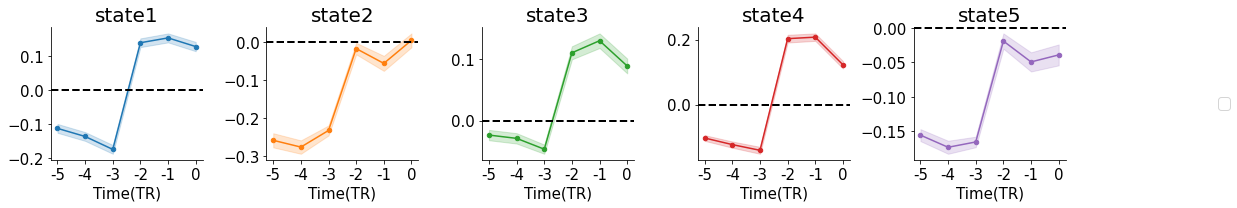

In [28]:
net_colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple']
roi_names = [f'state{k+1}' for k in range(K)]
state_names = [f'state{k+1}' for k in range(K)]

def plot_line(ax,m,e,idx_roi,label,color):
    ax.plot(m,label=label,color=color)
    ax.scatter(np.arange(winlen),m,color=color,s=20)
    ax.fill_between(np.arange(winlen),m-e,m+e,alpha=0.2,color=color)
    # ax.axvline(x=winlen//2-0.5,color='k',linestyle='-',linewidth=2)
    ax.axhline(y=0,color='k',linestyle='--',linewidth=2)

def plot_transitions(trans_list,color_list,nrows=3,ncols=3,figsize=(20,10)):
    fig,axs = plt.subplots(nrows=nrows,ncols=ncols,figsize=figsize,sharex=True,sharey=False)
    for i in trans_list:
        if nrows>1: ax = axs[i//ncols][i%ncols]
        else: ax = axs[i%ncols]
        plot_line(ax,m[i],e[i],i,None,net_colors[i])
        ax.set_title(state_names[i], fontsize=20)
        if i/ncols==1 and i%ncols==0:
            ax.set_ylabel('dist from attractor',fontsize=20)
            ax.yaxis.set_label_coords(-0.3,1.2)
        if nrows==1 or i//ncols==ncols-1: ax.set_xlabel('Time(TR)',fontsize=15)
        ax.set_xticks(np.arange(winlen))
        ax.set_xticklabels(np.arange(-winlen+1,1))
        ax.tick_params(axis='both', which='major', labelsize=15)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    fig.tight_layout(pad=0)
    return fig,axs

fig,axs = plot_transitions(trans_list,['black'],nrows=1,ncols=5,figsize=(15,3))
# fig.delaxes(axs[1][3])
# fig.delaxes(axs[1][2])
fig.legend(fontsize=16,loc='right',bbox_to_anchor=(1.15, 0.5))
fig.tight_layout()
# fig.savefig(f'figures/fig_state_transition_whole_brain_responses_K{K}.jpg',dpi=600,bbox_inches='tight')

100%|██████████| 400/400 [01:41<00:00,  3.94it/s]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


180
163
267
248
229


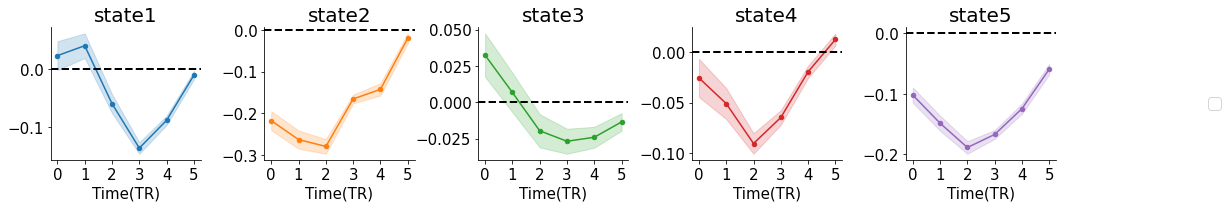

In [29]:
def get_transition_responses(y,z,st_i,win=winlen):
    ret = []
    for t in range(0,len(z)-win):
        if z[t]==st_i: 
            if t==0:
                if np.all(z[t:t+win]==st_i):
                    ret.append(y[t:t+win])
            elif z[t-1]!=st_i:
                if np.all(z[t:t+win]==st_i):
                    ret.append(y[t:t+win])
    if len(ret)>0: return np.mean(np.stack(ret,axis=0),axis=0)
    else: return None

resp = {trans:[] for trans in trans_list}
for idx_resample in tqdm(range(1,num_resamples+1)):
    df = all_dfs[idx_resample]
    state_mask = state_masks[idx_resample]
    for i in range(K):
        if state_mask[i]==1: continue
        if i not in trans_list: continue
        mean_resp = get_mean_transition_response(df,i)
        resp[i].append(mean_resp)

m = {trans:[] for trans in trans_list}
e = {trans:[] for trans in trans_list}
for trans in trans_list:
    print(len(resp[trans]))
    trans_responses = np.stack(resp[trans])
    m[trans] = np.mean(trans_responses,axis=0)
    e[trans] = (np.std(trans_responses,axis=0)*1.96)/np.sqrt(len(resp[trans])) #bootstrap_err_matrix(trans_responses)

def plot_transitions1(trans_list,color_list,nrows=3,ncols=3,figsize=(20,10)):
    fig,axs = plt.subplots(nrows=nrows,ncols=ncols,figsize=figsize,sharex=True,sharey=False)
    for i in trans_list:
        if nrows>1: ax = axs[i//ncols][i%ncols]
        else: ax = axs[i%ncols]
        plot_line(ax,m[i],e[i],i,None,net_colors[i])
        ax.set_title(state_names[i], fontsize=20)
        if i/ncols==1 and i%ncols==0:
            ax.set_ylabel('dist from attractor',fontsize=20)
            ax.yaxis.set_label_coords(-0.3,1.2)
        if nrows==1 or i//ncols==ncols-1: ax.set_xlabel('Time(TR)',fontsize=15)
        ax.set_xticks(np.arange(winlen))
        ax.tick_params(axis='both', which='major', labelsize=15)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    fig.tight_layout(pad=0)
    return fig,axs

fig,axs = plot_transitions1(trans_list,['black'],nrows=1,ncols=5,figsize=(15,3))
# fig.delaxes(axs[1][3])
# fig.delaxes(axs[1][2])
fig.legend(fontsize=16,loc='right',bbox_to_anchor=(1.15, 0.5))
fig.tight_layout()
# fig.savefig(f'figures/fig_state_transition_whole_brain_responses_K{K}.jpg',dpi=600,bbox_inches='tight')

In [30]:
winlen = 8
trans_list1 = ['02','24','43','32','21','10','03','34']
def get_transition_responses(y,z,st_i,st_j,win=winlen):
    ret = []
    for t in range(win//2-1,len(z)-win//2):
        if z[t]==st_i and z[t+1]==st_j:
            if np.all(z[t-win//2+1:t+1]==st_i) and np.all(z[t+1:t+win//2+1]==st_j):
                ret.append(y[t-win//2+1:t+win//2+1])
    if len(ret)>0: return np.mean(np.stack(ret,axis=0),axis=0)
    else: return None

def get_mean_transition_response(df,state_from,state_to):
    subj_list = df.pid.unique()
    trans_responses = []
    for pid in subj_list:
        count = 0
        df_subj = df[df.pid==pid]
        z_subj = np.hstack(list(df_subj.discrete_states.values))
        y_subj = np.hstack(list(df_subj['sims'].values))
        y_trans = get_transition_responses(y_subj,z_subj,state_from,state_to)
        if y_trans is not None: trans_responses.append(y_trans)
    trans_responses = np.stack(trans_responses,axis=0)
    mean_trans_response = trans_responses.mean(axis=0)
    return mean_trans_response

resp = {trans:[] for trans in trans_list1}
for idx_resample in tqdm(range(1,num_resamples+1)):
    df = all_dfs[idx_resample]
    state_mask = state_masks[idx_resample]
    for i in range(K):
        for j in range(K):
            if state_mask[i]==1 or state_mask[j]==1: continue
            if f'{i}{j}' not in trans_list1: continue
            mean_resp = get_mean_transition_response(df,i,j)
            resp[f'{i}{j}'].append(mean_resp)

m = {trans:[] for trans in trans_list1}
e = {trans:[] for trans in trans_list1}
for trans in trans_list1:
    print(len(resp[trans]))
    trans_responses = np.stack(resp[trans])
    m[trans] = np.mean(trans_responses,axis=0)
    e[trans] = (np.std(trans_responses,axis=0)*1.96)/np.sqrt(len(resp[trans]))

  0%|          | 0/400 [00:00<?, ?it/s]

100%|██████████| 400/400 [01:20<00:00,  4.94it/s]

120
153
135
128
96
72
104
135


IndexError: list index out of range

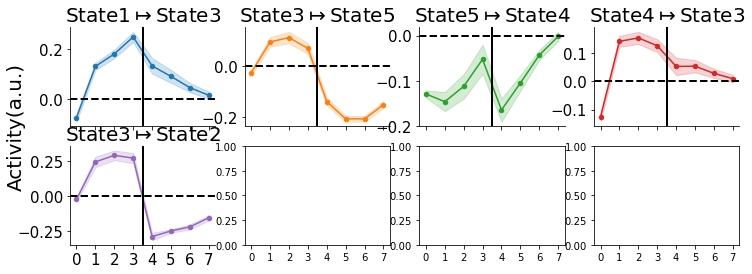

In [31]:
state_names = [f'State{i+1}' for i in range(K)]

def plot_line(ax,m,e,idx_roi,label,color):
    ax.plot(m,label=label,color=color)
    ax.scatter(np.arange(winlen),m,color=color,s=20)
    ax.fill_between(np.arange(winlen),m-e,m+e,alpha=0.2,color=color)
    ax.axvline(x=winlen//2-0.5,color='k',linestyle='-',linewidth=2)
    ax.axhline(y=0,color='k',linestyle='--',linewidth=2)

def plot_transitions(trans_list,color_list,nrows=3,ncols=3,figsize=(20,10)):
    label_list = [f'{state_names[int(i)//10]}$\mapsto${state_names[int(i)%10]}' for i in trans_list]
    fig,axs = plt.subplots(nrows=nrows,ncols=ncols,figsize=figsize,sharex=True,sharey=False)
    for i,trans in enumerate(trans_list1):
        if nrows>1: ax = axs[i//ncols][i%ncols]
        else: ax = axs[i%ncols]
        fr,to = int(trans[0]),int(trans[1])
        plot_line(ax,m[trans],e[trans],0,None,net_colors[i])
        ax.set_title(label_list[i], fontsize=20)
        if i/ncols==1 and i%ncols==0:
            ax.set_ylabel('Activity(a.u.)',fontsize=20)
            ax.yaxis.set_label_coords(-0.3,1.2)
        if nrows==1 or i//ncols==ncols-1: ax.set_xlabel('Time(TR)',fontsize=15)
        ax.set_xticks(np.arange(winlen))
        ax.tick_params(axis='both', which='major', labelsize=15)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    fig.tight_layout(pad=0)
    return fig,axs


fig,axs = plot_transitions(trans_list1,['black'],nrows=2,ncols=4,figsize=(12,4))
# fig.delaxes(axs[1][3])
# fig.delaxes(axs[1][2])
fig.legend(fontsize=16,loc='right',bbox_to_anchor=(1.3, 0.5))
fig.tight_layout()
fig.savefig(f'figures/fig_state_transition_whole_brain_responses_K{K}.jpg',dpi=600,bbox_inches='tight')